### In this notebook we generate simulated GW data using PyCBC's `FDomainDetFrameGenerator` class for `IMRPhenomXHM`.

In [44]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import h5py
import json

import statistics

import numpy as np
from numpy.fft import fft, ifft
from scipy.interpolate import interp1d
from scipy import signal
from scipy.signal import butter, filtfilt

import pycbc
from pycbc import noise
from pycbc.waveform import get_fd_waveform, get_waveform_filter_length_in_time as chirplen
from pycbc.waveform.generator import (FDomainDetFrameGenerator, FDomainCBCGenerator)
from pycbc.psd import aLIGOZeroDetHighPower, AdVDesignSensitivityP1200087
from pycbc.noise.gaussian import frequency_noise_from_psd
from pycbc.filter.matchedfilter import matched_filter
import lal

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from helperfn import *  

# plotting items
%matplotlib inline


In [45]:
## The parameters of the binary...

m1, m2, s1z, s2z = 9., 8., 0., 0.
distance = 320
fsamp , flow , fhigh = 2048 , 10 , 1024
fband = [15 , 170]
iota = np.pi / 4                   # Inclination angle
phic = np.pi / 3                   # Coalescence phase
psi = 0                            # Polarization Angle
tStart = 1367469555                # GPS time for the epoch, which corresponds to 7May2023-04:38:57UTC.
dt = 1/fsamp                       # Time resolution 
ifos= ['L1' , 'H1' , 'V1']         # Detectors 

mode_array = [[2, 2]]

## Assign some values to the variable parameters to generate waveforms in detectors:`ifos`.
alpha = np.pi/2.5                             # Right Ascension
delta = -np.pi/6                              # Declination
psi = 0                                       # Polarization angle

## Generate data colored with psd.
seed = 1

#Initialize the RNG with the chosen seed
np.random.seed(seed)

In [46]:
signalDuration, delta_f, Nt, Nf = calculate_signal_duration("IMRPhenomD", m1, m2, s1z, s2z, flow, fsamp)

print(f'Signal Duration: {signalDuration} Seconds')

tTrigger = tStart + signalDuration

Signal Duration: 55.87035361764925 Seconds


### Generate signal and noisy data time series.

Several time-series are generated - with and without whitening, band

In [47]:
# Using PyCBC's `FDomainDetframeGenerator` class to generate a coherent signal.
# `frozenParams` and `locationParams` are the parameters of injection.

#-- Dictionary of parameters that remain fixed during signal generation
frozenParams = {
    'approximant': "IMRPhenomD",
    'mass1': m1,
    'mass2': m2,
    'spin1z': s1z,
    'spin2z': s2z,
    'delta_f': delta_f,
    'f_lower': flow,
    'f_final': fhigh,                     
    'inclination': iota,
    'distance': distance,                  
    'mode_array': mode_array,
    'coa_phase': phic
}

#-- Generating Signal in Frequency Domain
signal_L1H1V1= Signal_Generation(m1, m2, s1z, s2z, distance, alpha, delta, signalDuration, frozenParams, tStart, psi , Nf)

# Generate psd: Using analytical psds `AdVDesignSensitivityP1200087` for Virgo and `aLIGOZeroDetHighPower` for both LIGO detectors.
psd_V1 = AdVDesignSensitivityP1200087(Nf, delta_f = delta_f, low_freq_cutoff = flow)
psd_L1H1 = aLIGOZeroDetHighPower(Nf, delta_f = delta_f, low_freq_cutoff = flow)
psd = {'L1' : psd_L1H1, 'H1' : psd_L1H1, 'V1' : psd_V1}


noise = {}

data_fd = {}
data_td = {}

signal_L1H1V1_td = {}

signal_whiten = {}
data_whiten = {}

signal_whitenbp = {}
data_whitenbp = {}

for detector in ifos:
    
    print(f'Generating data in frequency domain in {detector}... in a frequency band {fband} Hz')
    signal_L1H1V1_td[detector] = signal_L1H1V1[detector].to_timeseries()
    
    # Generate Gaussian noise.
    noise[detector] = frequency_noise_from_psd(psd[detector])
    
    # Adding Gaussian noise in signal to generate data.
    data_fd[detector] = signal_L1H1V1[detector] + noise[detector]
    data_td[detector] = data_fd[detector].to_timeseries()

    # fix the zeros in the PSD values
    psd[detector].data[np.where(psd[detector].data == 0)[0]] = 10**(-50)

    # whiten the data and signal
    signal_whiten[detector] = whiten(signal_L1H1V1[detector], psd[detector])
    data_whiten[detector] = whiten(data_fd[detector], psd[detector])

    # finally, bp the whitened data
    signal_whitenbp[detector] = bandpass(signal_whiten[detector], fband, data_whiten[detector].get_sample_rate())
    data_whitenbp[detector] = bandpass(data_whiten[detector], fband, data_whiten[detector].get_sample_rate())

Generating data in frequency domain in L1... in a frequency band [15, 170] Hz
Generating data in frequency domain in H1... in a frequency band [15, 170] Hz
Generating data in frequency domain in V1... in a frequency band [15, 170] Hz


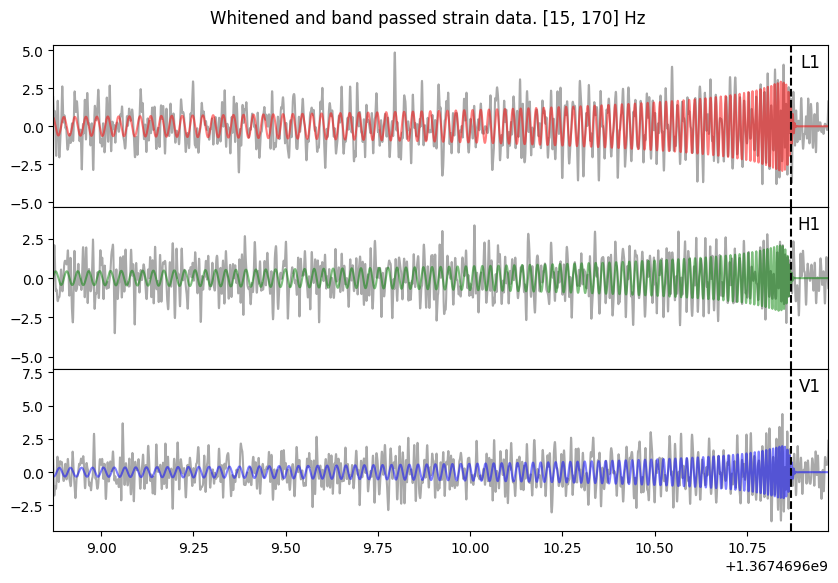

In [48]:
# Plotting whitened and BP data and signal in all the detectors.
fig, ax = plt.subplots(len(ifos), 1, sharex = True, figsize = (10, 6))
fig.subplots_adjust(hspace = 0)

fig.suptitle(f'Whitened and band passed strain data. {fband} Hz')
fig.subplots_adjust(top=0.92)

c = ['r', 'g', 'b']

for i, ifo in enumerate(ifos):
    ax[i].plot(data_whitenbp[ifo].sample_times, data_whitenbp[ifo], c = 'darkgray')
    ax[i].plot(signal_whitenbp[ifo].sample_times, signal_whitenbp[ifo], c = c[i], alpha = 0.5)
    ax[i].axvline(x = tTrigger, c = 'k', ls = '--')
    
    ax[i].set_title(ifo, x = 0.99, y = 0.95, pad = -10, fontsize = 12, loc='right')
    ax[i].set_xlim(tTrigger - 2, tTrigger + 0.1)

### Matched filtering SNR time series

Calculating matched-filter SNR in three detectors. Frequency band: [15, 170] Hz


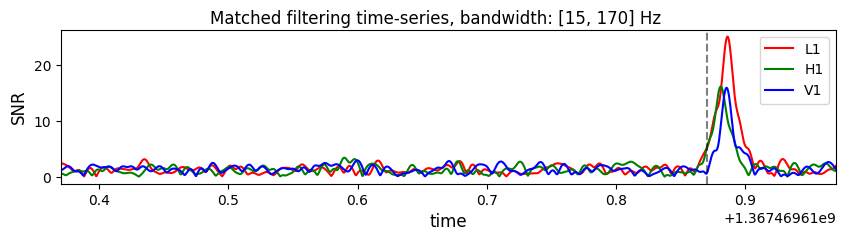

{'L1': 25.1, 'H1': 16.19, 'V1': 15.96}


In [49]:
# Caculate matched-filter SNR in all the detectors.
print(f'Calculating matched-filter SNR in three detectors. Frequency band: {fband} Hz')

# To calculate the matched filter we need a template waveform, let us generate a template using `get_fd_waveform`.
SNR , matchedFilterSNR = matchfiltering(frozenParams , psd , data_fd , fband,  ifos , Nf)


# Plotting the SNR time series.
fig, ax = plt.subplots(figsize = (10, 2))
fig.suptitle(f'Matched filtering time-series, bandwidth: {fband} Hz')
fig.subplots_adjust(top=0.88)

ax.set_prop_cycle(color=['red', 'green', 'blue', 'magenta'])

for i, ifo in enumerate(ifos):
    ax.plot(matchedFilterSNR[ifo].sample_times, matchedFilterSNR[ifo], label = ifo)
    
ax.axvline(x = tTrigger, c = 'k', ls = '--', alpha=0.5)
ax.set_xlabel('time', fontsize = 12)
ax.set_ylabel('SNR', fontsize = 12)
ax.set_xlim(tTrigger - 0.5, tTrigger + 0.1)
plt.legend()

plt.show()
print(SNR)


### Plot the cross correlation vs time-lag

Trigger GPS time: 1367469610.8703537 s
Calculating cross-corr using [-3.5, 1.5] s of data around reference GPS time 1367469610.6203537
Reference time is -0.25 s away from the trigger time


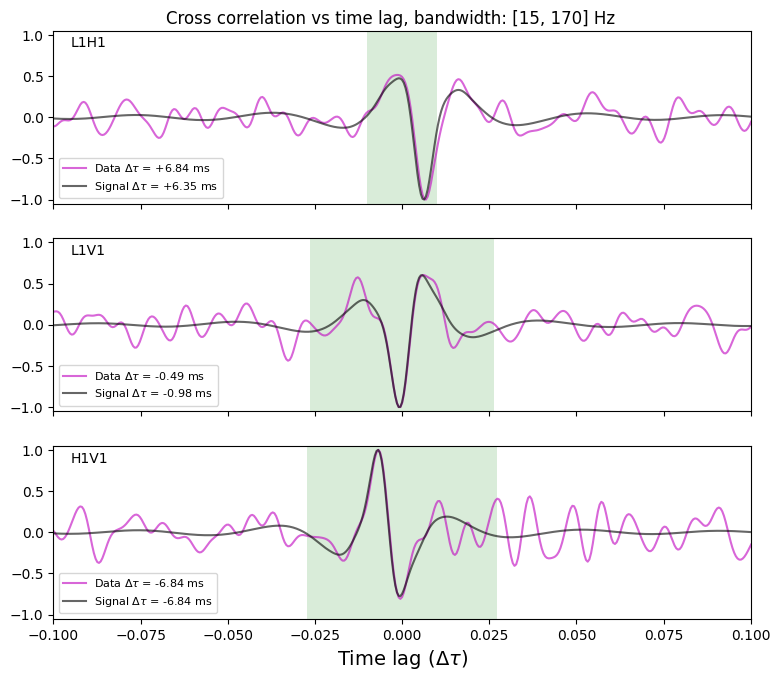

In [50]:
fig, ax = plt.subplots(len(ifos), 1, sharex = True, figsize = (9, 7))

fig.suptitle(f'Cross correlation vs time lag, bandwidth: {fband} Hz')
fig.subplots_adjust(top=0.95)

light_time = {'L1H1':0.010012846152267725, 'L1V1':0.02644834101635671, 'H1V1':0.027287979933397113}
tInterval = [-3.5, 1.5]
tRef = tTrigger - .25

print (f'Trigger GPS time: {tTrigger} s')
print (f'Calculating cross-corr using {tInterval} s of data around reference GPS time {tRef}')
print (f'Reference time is {tRef - tTrigger} s away from the trigger time')

# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["m", "k", "c"]) 
p = 0

for i, ifoA in enumerate(ifos):
    for j, ifoB in enumerate(ifos):  
        
        if j>i: 
            
            #--------- For noisy data
            lagxy, corrxy = calc_xcorr(data_whitenbp[ifoA], data_whitenbp[ifoB], tRef, tInterval, ifnormalize=True)
            #-- calculate the time-lag between the signals
            lt_AB = light_time[f'{ifoA}{ifoB}'] #-- look up the light travel time
            
            k = np.where(np.abs(lagxy) <= lt_AB)
            idx = np.abs(corrxy[k]).argmax() + k[0][0]
            lag = lagxy[idx]

            ax[p].axvspan(-lt_AB, lt_AB, facecolor='g', alpha=0.15)
            ax[p].plot(lagxy, corrxy, label=rf'Data $\Delta\tau$ = {lag*1000:+.2f} ms', alpha=0.6)            

            #---------- For pure signals (no noise)
            lagxy, corrxy = calc_xcorr(signal_whitenbp[ifoA], signal_whitenbp[ifoB], tRef, tInterval, ifnormalize=True)

            #-- calculate the time-lag between the signals
            k = np.where(np.abs(lagxy) <= lt_AB) # light-travel time only
            idx = np.abs(corrxy[k]).argmax() + k[0][0]
            lag = lagxy[idx]
            
            ax[p].plot(lagxy, corrxy, label=rf'Signal $\Delta\tau$ = {lag*1000:+.2f} ms', alpha=0.6)

            ax[p].text(-.095, 0.85, f'{ifoA}{ifoB}')
            ax[p].set_xlim(-.10, 0.10)
            ax[p].set_ylim(-1.05, 1.05)
            ax[p].legend(fontsize=8, loc=3)
            
            plt.xlabel(r'Time lag ($\Delta\tau$)', fontsize=14)
            
            p += 1

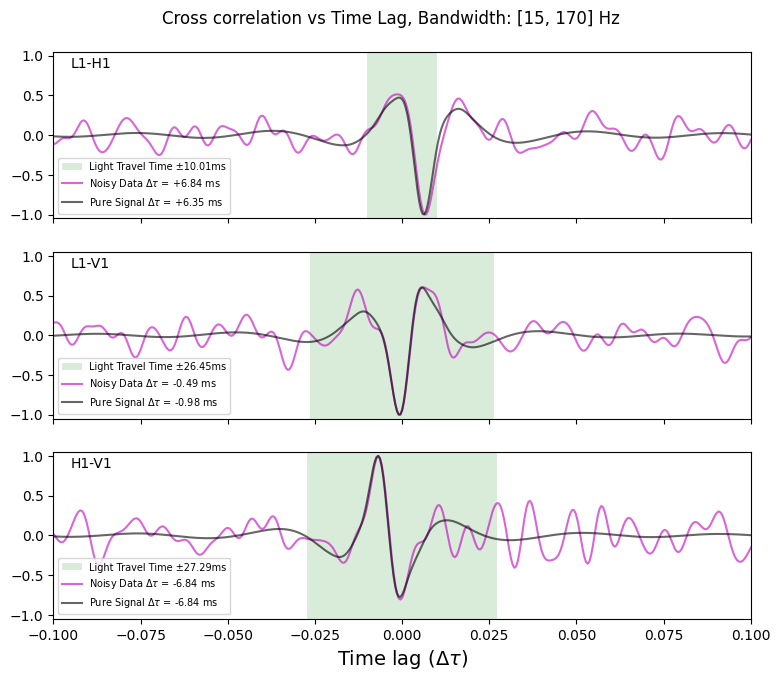

In [51]:
time_lag_n , time_lag_s = calculate_time_lag(ifos , tRef ,tInterval , data_whitenbp , signal_whitenbp , light_time , fband ,tTrigger , plot = True)

In [52]:
time_lag_n , time_lag_s

({'L1H1': 6.84, 'L1V1': -0.49, 'H1V1': -6.84},
 {'L1H1': 6.35, 'L1V1': -0.98, 'H1V1': -6.84})

In [53]:
Fbands = ( (15 , 170) ,(10 , 50), (10 , 100) , (10 , 200) , (10 ,300) ,(10 , 400) , (10 , 500))
np.random.seed(1)
Time_lags_Noise = {}
Time_lags_Signal = {}

signalDuration, delta_f, Nt, Nf = calculate_signal_duration("IMRPhenomD", m1, m2, s1z, s2z, flow, fsamp)
tTrigger = tStart + signalDuration
signal_L1H1V1= Signal_Generation(m1, m2, s1z, s2z, distance, alpha, delta, signalDuration, frozenParams, tStart, psi , Nf)

# Generate psd: Using analytical psds `AdVDesignSensitivityP1200087` for Virgo and `aLIGOZeroDetHighPower` for both LIGO detectors.
psd_V1 = AdVDesignSensitivityP1200087(Nf, delta_f = delta_f, low_freq_cutoff = flow)
psd_L1H1 = aLIGOZeroDetHighPower(Nf, delta_f = delta_f, low_freq_cutoff = flow)
psd = {'L1' : psd_L1H1, 'H1' : psd_L1H1, 'V1' : psd_V1}
for fband in Fbands:
    results = generate_and_process_data(ifos, signal_L1H1V1, psd, fband)
    data_whitenbp = results['data_whitenbp']
    signal_whitenbp = results['signal_whitenbp']
    time_lag_n , time_lag_s = calculate_time_lag(ifos , tRef ,tInterval , data_whitenbp , signal_whitenbp , light_time , fband ,tTrigger , plot = False)
    Time_lags_Noise[fband] = time_lag_n 
    Time_lags_Signal[fband] = time_lag_s

In [54]:
delta_ratios = calculate_delta_ratios(Fbands, Time_lags_Noise, Time_lags_Signal)
Time_lags_Noise  ,  Time_lags_Signal

({(15, 170): {'L1H1': 6.84, 'L1V1': -0.49, 'H1V1': -6.84},
  (10, 50): {'L1H1': 6.84, 'L1V1': -2.93, 'H1V1': 2.93},
  (10, 100): {'L1H1': 6.84, 'L1V1': -0.98, 'H1V1': -8.3},
  (10, 200): {'L1H1': 6.84, 'L1V1': -0.98, 'H1V1': -8.3},
  (10, 300): {'L1H1': 5.37, 'L1V1': -0.49, 'H1V1': -0.49},
  (10, 400): {'L1H1': 5.86, 'L1V1': -2.44, 'H1V1': -5.86},
  (10, 500): {'L1H1': 5.86, 'L1V1': 7.81, 'H1V1': -6.84}},
 {(15, 170): {'L1H1': 6.35, 'L1V1': -0.98, 'H1V1': -6.84},
  (10, 50): {'L1H1': 6.84, 'L1V1': -2.44, 'H1V1': -9.28},
  (10, 100): {'L1H1': 6.35, 'L1V1': -1.46, 'H1V1': -7.81},
  (10, 200): {'L1H1': 6.35, 'L1V1': -0.49, 'H1V1': -6.84},
  (10, 300): {'L1H1': 5.86, 'L1V1': -0.49, 'H1V1': -6.35},
  (10, 400): {'L1H1': 5.86, 'L1V1': -0.49, 'H1V1': -6.35},
  (10, 500): {'L1H1': 5.86, 'L1V1': 1e-50, 'H1V1': -6.35}})

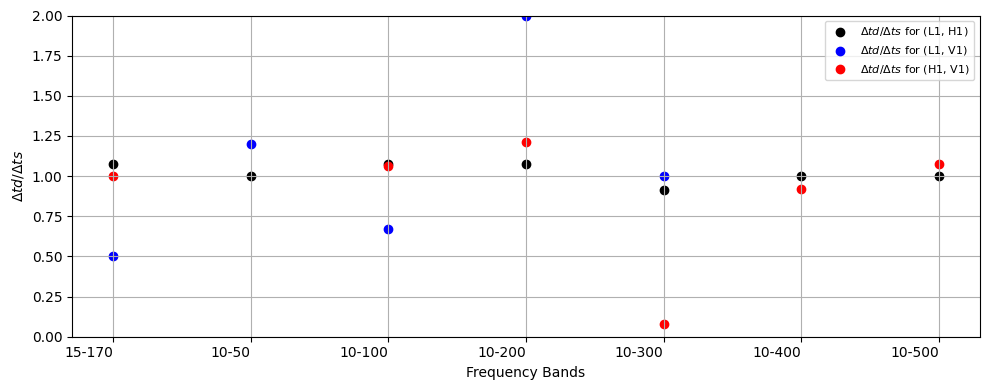

In [55]:
plot_deltas( delta_ratios['L1_H1'], delta_ratios['H1_V1'], delta_ratios['L1_V1'], Fbands)

In [72]:

## The parameters of the binary...

m1, m2, s1z, s2z = 9., 8., 0., 0.
distance = 100
fsamp , flow , fhigh = 2048 , 10 , 1024
iota = np.pi / 4                   # Inclination angle
phic = np.pi / 3                   # Coalescence phase
psi = 0                            # Polarization Angle
tStart = 1367469555                # GPS time for the epoch, which corresponds to 7May2023-04:38:57UTC.
dt = 1/fsamp                       # Time resolution 
ifos= ['L1' , 'H1' , 'V1']         # Detectors 

mode_array = [[2, 2]]

## Assign some values to the variable parameters to generate waveforms in detectors:`ifos`.

psi = 0                                       # Polarization angle

Fbands = ((15 , 170), (10 , 50) , (10 , 100) , (10 , 200) , (10 ,300) ,(10 , 400) , (10 , 500) , (10 , 600))

light_time = {'L1H1':0.010012846152267725, 'L1V1':0.02644834101635671, 'H1V1':0.027287979933397113}

tInterval = [-4.5, -1]
tRef = tTrigger


frozenParams = {
    'approximant': "IMRPhenomD",
    'mass1': m1,
    'mass2': m2,
    'spin1z': s1z,
    'spin2z': s2z,
    'delta_f': delta_f,
    'f_lower': flow,
    'f_final': fhigh,                     
    'inclination': iota,
    'distance': distance,                  
    'mode_array': mode_array,
    'coa_phase': phic  }


SNR for (15, 170) is {'L1': 80.16, 'H1': 55.1, 'V1': 48.2}
SNR for (10, 50) is {'L1': 55.0, 'H1': 38.11, 'V1': 27.4}
SNR for (10, 100) is {'L1': 74.26, 'H1': 52.64, 'V1': 40.48}
SNR for (10, 200) is {'L1': 81.05, 'H1': 59.26, 'V1': 47.21}
SNR for (10, 300) is {'L1': 83.62, 'H1': 58.8, 'V1': 48.6}
SNR for (10, 400) is {'L1': 84.33, 'H1': 59.49, 'V1': 50.95}
SNR for (10, 500) is {'L1': 85.03, 'H1': 60.52, 'V1': 49.96}
SNR for (10, 600) is {'L1': 83.49, 'H1': 59.13, 'V1': 50.4}
Plotting deltas for different alpha 1.2566370614359172 and delta -0.5235987755982988 values


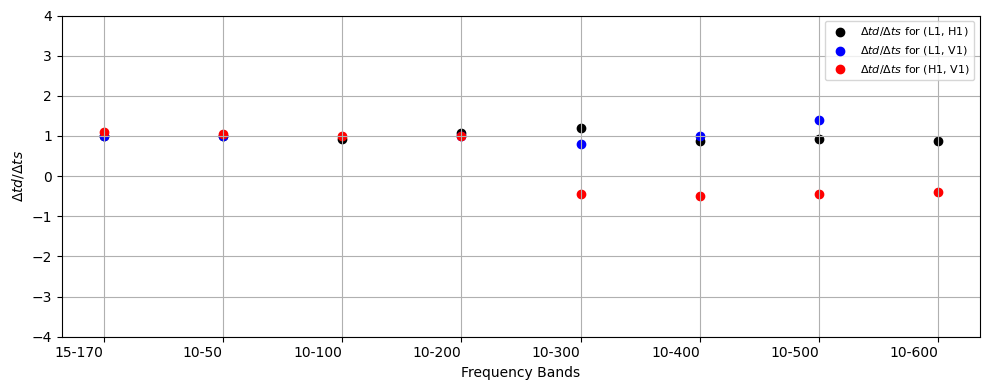

SNR for (15, 170) is {'L1': 56.07, 'H1': 71.32, 'V1': 42.12}
SNR for (10, 50) is {'L1': 40.83, 'H1': 47.05, 'V1': 25.18}
SNR for (10, 100) is {'L1': 54.62, 'H1': 66.11, 'V1': 40.41}
SNR for (10, 200) is {'L1': 58.5, 'H1': 70.68, 'V1': 45.6}
SNR for (10, 300) is {'L1': 59.4, 'H1': 75.93, 'V1': 45.41}
SNR for (10, 400) is {'L1': 59.68, 'H1': 74.9, 'V1': 46.02}
SNR for (10, 500) is {'L1': 60.33, 'H1': 75.12, 'V1': 45.98}
SNR for (10, 600) is {'L1': 60.84, 'H1': 75.26, 'V1': 49.03}
Plotting deltas for different alpha 1.2566370614359172 and delta 1.5707963267948966 values


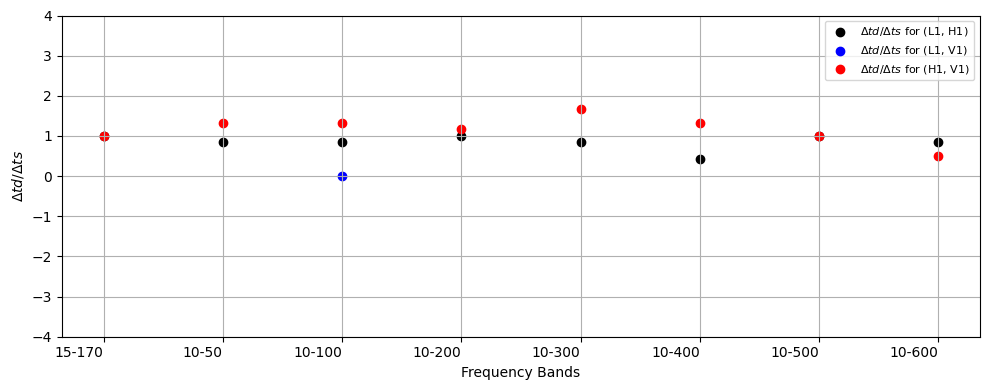

SNR for (15, 170) is {'L1': 47.65, 'H1': 63.27, 'V1': 34.01}
SNR for (10, 50) is {'L1': 33.49, 'H1': 43.9, 'V1': 17.92}
SNR for (10, 100) is {'L1': 47.72, 'H1': 58.0, 'V1': 29.92}
SNR for (10, 200) is {'L1': 49.27, 'H1': 65.83, 'V1': 34.79}
SNR for (10, 300) is {'L1': 51.6, 'H1': 65.22, 'V1': 35.35}
SNR for (10, 400) is {'L1': 50.39, 'H1': 67.54, 'V1': 37.26}
SNR for (10, 500) is {'L1': 51.91, 'H1': 65.98, 'V1': 36.86}
SNR for (10, 600) is {'L1': 50.95, 'H1': 67.64, 'V1': 35.55}
Plotting deltas for different alpha 1.2566370614359172 and delta 1.0471975511965976 values


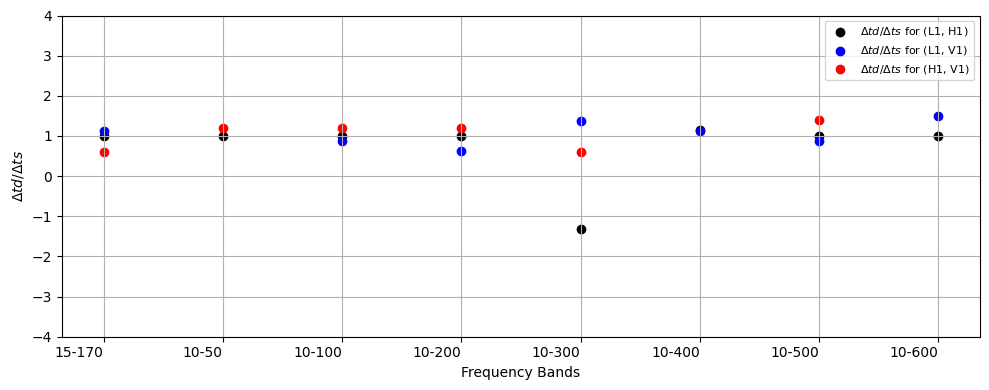

SNR for (15, 170) is {'L1': 101.52, 'H1': 87.9, 'V1': 32.72}
SNR for (10, 50) is {'L1': 67.85, 'H1': 59.23, 'V1': 17.05}
SNR for (10, 100) is {'L1': 93.86, 'H1': 79.8, 'V1': 28.22}
SNR for (10, 200) is {'L1': 102.48, 'H1': 86.65, 'V1': 31.94}
SNR for (10, 300) is {'L1': 104.78, 'H1': 90.62, 'V1': 33.37}
SNR for (10, 400) is {'L1': 107.0, 'H1': 89.38, 'V1': 33.27}
SNR for (10, 500) is {'L1': 106.94, 'H1': 89.83, 'V1': 35.44}
SNR for (10, 600) is {'L1': 106.53, 'H1': 91.98, 'V1': 35.45}
Plotting deltas for different alpha 0.5235987755982988 and delta -0.5235987755982988 values


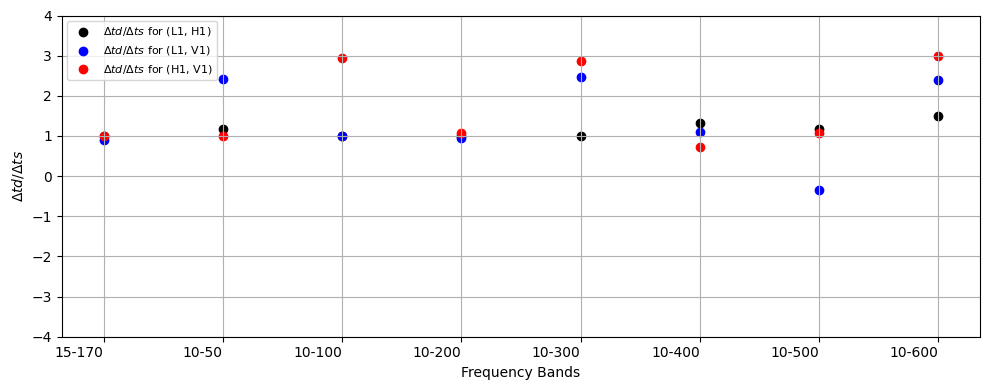

SNR for (15, 170) is {'L1': 59.82, 'H1': 73.49, 'V1': 44.47}
SNR for (10, 50) is {'L1': 40.38, 'H1': 51.55, 'V1': 27.85}
SNR for (10, 100) is {'L1': 55.56, 'H1': 70.82, 'V1': 40.13}
SNR for (10, 200) is {'L1': 60.91, 'H1': 77.12, 'V1': 45.83}
SNR for (10, 300) is {'L1': 63.15, 'H1': 78.33, 'V1': 48.02}
SNR for (10, 400) is {'L1': 65.15, 'H1': 79.38, 'V1': 48.3}
SNR for (10, 500) is {'L1': 62.81, 'H1': 76.91, 'V1': 49.51}
SNR for (10, 600) is {'L1': 63.93, 'H1': 80.83, 'V1': 48.66}
Plotting deltas for different alpha 0.5235987755982988 and delta 1.5707963267948966 values


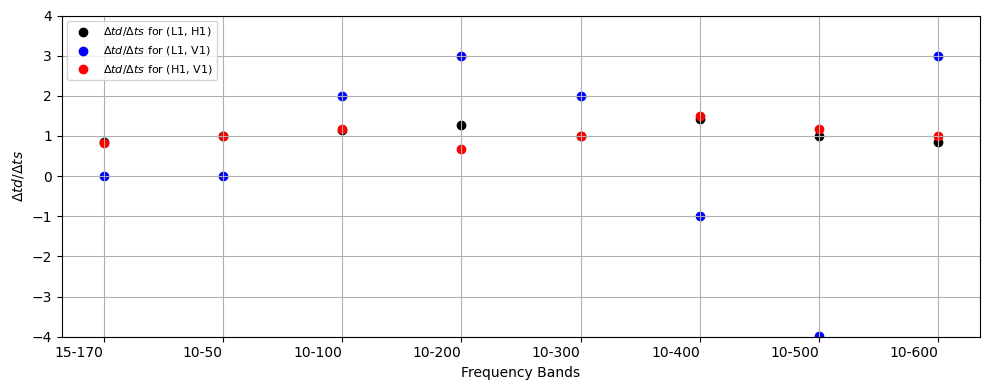

SNR for (15, 170) is {'L1': 44.23, 'H1': 49.6, 'V1': 42.31}
SNR for (10, 50) is {'L1': 31.0, 'H1': 33.72, 'V1': 24.15}
SNR for (10, 100) is {'L1': 40.34, 'H1': 47.92, 'V1': 36.29}
SNR for (10, 200) is {'L1': 44.06, 'H1': 51.8, 'V1': 41.27}
SNR for (10, 300) is {'L1': 46.15, 'H1': 54.08, 'V1': 45.19}
SNR for (10, 400) is {'L1': 47.18, 'H1': 51.87, 'V1': 45.86}
SNR for (10, 500) is {'L1': 48.13, 'H1': 52.92, 'V1': 47.15}
SNR for (10, 600) is {'L1': 46.77, 'H1': 52.81, 'V1': 45.43}
Plotting deltas for different alpha 0.5235987755982988 and delta 1.0471975511965976 values


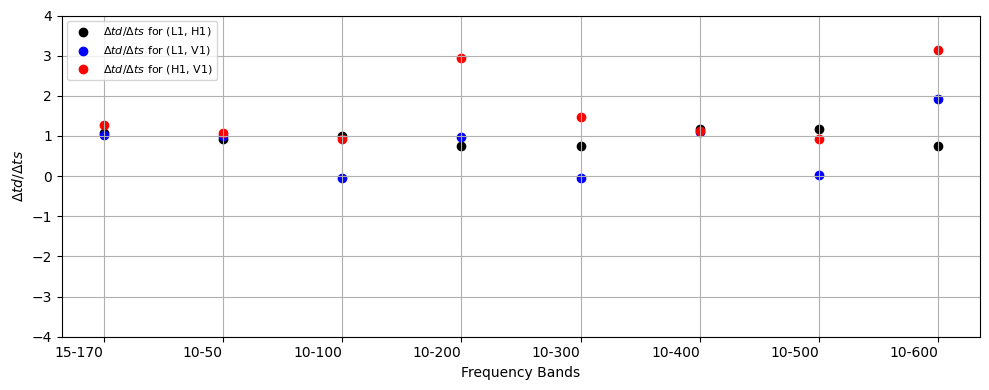

SNR for (15, 170) is {'L1': 43.78, 'H1': 30.17, 'V1': 43.92}
SNR for (10, 50) is {'L1': 30.2, 'H1': 21.3, 'V1': 26.37}
SNR for (10, 100) is {'L1': 39.94, 'H1': 27.49, 'V1': 40.59}
SNR for (10, 200) is {'L1': 43.57, 'H1': 30.06, 'V1': 45.54}
SNR for (10, 300) is {'L1': 45.18, 'H1': 33.06, 'V1': 47.66}
SNR for (10, 400) is {'L1': 46.78, 'H1': 32.34, 'V1': 47.5}
SNR for (10, 500) is {'L1': 44.56, 'H1': 33.36, 'V1': 48.3}
SNR for (10, 600) is {'L1': 46.18, 'H1': 32.59, 'V1': 47.37}
Plotting deltas for different alpha 3.141592653589793 and delta -0.5235987755982988 values


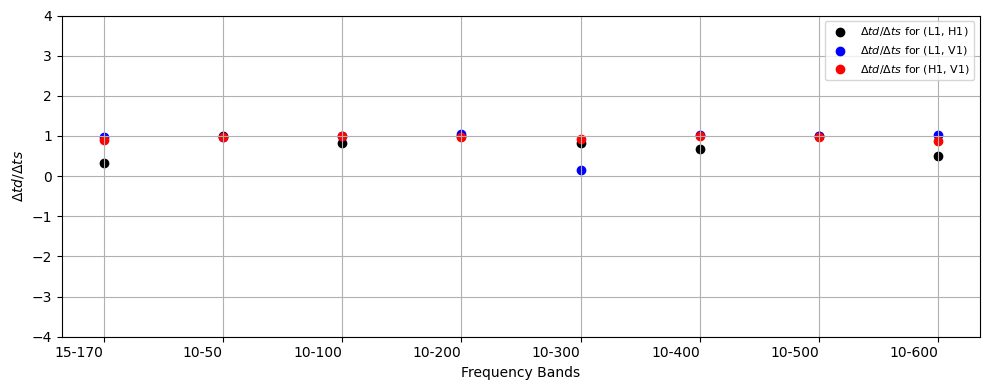

SNR for (15, 170) is {'L1': 58.48, 'H1': 72.42, 'V1': 44.09}
SNR for (10, 50) is {'L1': 40.18, 'H1': 49.43, 'V1': 27.27}
SNR for (10, 100) is {'L1': 52.31, 'H1': 66.34, 'V1': 40.23}
SNR for (10, 200) is {'L1': 57.31, 'H1': 72.07, 'V1': 45.9}
SNR for (10, 300) is {'L1': 57.86, 'H1': 74.14, 'V1': 48.06}
SNR for (10, 400) is {'L1': 61.05, 'H1': 74.43, 'V1': 48.66}
SNR for (10, 500) is {'L1': 60.43, 'H1': 76.09, 'V1': 49.45}
SNR for (10, 600) is {'L1': 59.29, 'H1': 74.5, 'V1': 49.52}
Plotting deltas for different alpha 3.141592653589793 and delta 1.5707963267948966 values


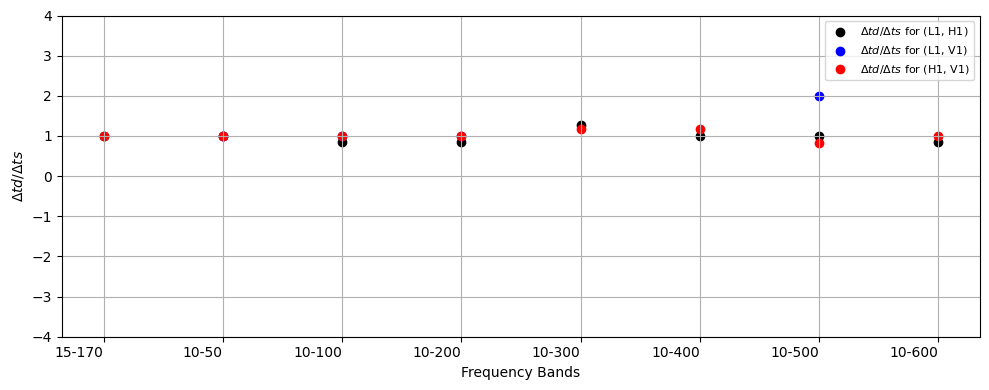

SNR for (15, 170) is {'L1': 82.72, 'H1': 93.75, 'V1': 23.9}
SNR for (10, 50) is {'L1': 57.58, 'H1': 64.83, 'V1': 14.62}
SNR for (10, 100) is {'L1': 75.07, 'H1': 88.1, 'V1': 20.15}
SNR for (10, 200) is {'L1': 84.28, 'H1': 96.06, 'V1': 27.09}
SNR for (10, 300) is {'L1': 86.59, 'H1': 100.4, 'V1': 24.58}
SNR for (10, 400) is {'L1': 87.41, 'H1': 100.85, 'V1': 26.42}
SNR for (10, 500) is {'L1': 88.01, 'H1': 99.61, 'V1': 24.93}
SNR for (10, 600) is {'L1': 87.08, 'H1': 99.24, 'V1': 25.11}
Plotting deltas for different alpha 3.141592653589793 and delta 1.0471975511965976 values


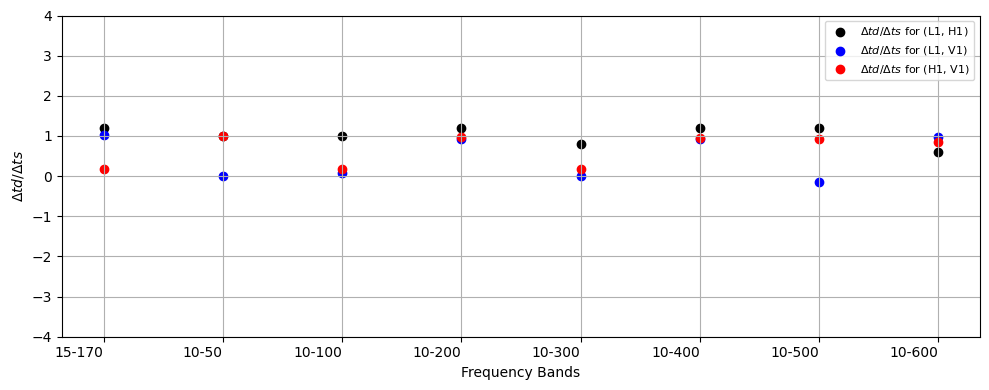

In [73]:

Alphas = ( np.pi/2.5 , np.pi/6 , np.pi)
Deltas = (- np.pi/6 , np.pi/2 , np.pi/3)

np.random.seed(1)


for alpha in Alphas:
    for delta in Deltas:
        signalDuration, delta_f, Nt, Nf = calculate_signal_duration("IMRPhenomD", m1, m2, s1z, s2z, flow, fsamp)
        frozenParams['delta_f'] = delta_f
        
        tTrigger = tStart + signalDuration
        
        signal_L1H1V1= Signal_Generation(m1, m2, s1z, s2z, distance, alpha, delta, signalDuration, frozenParams, tStart, psi , Nf)

        # Generate psd: Using analytical psds `AdVDesignSensitivityP1200087` for Virgo and `aLIGOZeroDetHighPower` for both LIGO detectors.
        psd_V1 = AdVDesignSensitivityP1200087(Nf, delta_f = delta_f, low_freq_cutoff = flow)
        psd_L1H1 = aLIGOZeroDetHighPower(Nf, delta_f = delta_f, low_freq_cutoff = flow)
        psd = {'L1' : psd_L1H1, 'H1' : psd_L1H1, 'V1' : psd_V1}


        Time_lags_Noise = {}
        Time_lags_Signal = {}
        for fband in Fbands:
            results = generate_and_process_data(ifos, signal_L1H1V1, psd, fband)
            data_fd = results['data_fd']
            SNR , _ = matchfiltering(frozenParams , psd , data_fd , fband,  ifos , Nf)
            print(f'SNR for {fband} is {SNR}')
            data_whitenbp = results['data_whitenbp']
            signal_whitenbp = results['signal_whitenbp']
            time_lag_n , time_lag_s = calculate_time_lag(ifos , tRef ,tInterval , data_whitenbp , signal_whitenbp , light_time , fband ,tTrigger , plot = False)
            Time_lags_Noise[fband] = time_lag_n 
            Time_lags_Signal[fband] = time_lag_s
            

        print(f'Plotting deltas for different alpha {alpha} and delta {delta} values')    
        delta_ratios = calculate_delta_ratios(Fbands, Time_lags_Noise, Time_lags_Signal)

        plot_deltas( delta_ratios['L1_H1'], delta_ratios['H1_V1'], delta_ratios['L1_V1'], Fbands, ylim = (-4 , 4))

        # Clear dictionaries for the next iteration
        Time_lags_Noise.clear()
        Time_lags_Signal.clear()
